In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import duckdb
from mriomain import mrio

In [2]:
input_mrio = '../data/mrio.parquet'
input_ee = '../data/ee.parquet'
countries_mapping = pd.read_excel('../data/raw/countries.xlsx')
sectors_mapping = pd.read_csv('../data/raw/sectors.csv')

years = [2017, 2018, 2019, 2020, 2021]

## Industrial Sectors

_**Carbon leakage**_: Transfer of emissions from one jurisdiction to another due to the implementation of climate policies to regulate certain sectors
- Effect: <u>reduced competitiveness</u> of domestic sectors <u>without achieving mitigation objectives</u> (on a global perspective)
- In some jurisdictions, governments are reluctant to introduce carbon pricing schemes (where sectors incur additional cost proportional to emissions) or certain sectors are exempted out of mitigation policies due to risk of carbon leakage
- Relevance: understanding carbon leakage risk in industrial sectors informs climate policies (e.g. sectors with low leakage risk can be included in mitigation efforts, anti-leakage mechanisms can be established for sectors with high carbon leakage risk)

**Objectives**

1. Defining emission intensity and trade exposure of industrial sectors
2. Quantifying carbon leakage risk


### A. Emission Impact Ratio (EIR)
Volume of a country-sector's GHG emissions (direct + indirect) / country-sector's GVA
* *EIR Direct* - emissions resulting from a country-sector's production / country-sector's GVA
* *EIR Indirect* - emissions resulting from the production of a country-sector's inputs / country-sector's GVA

In [264]:
# column labels
df = duckdb.sql(f"SELECT * FROM '{input_ee}'").df()
labels = df.columns[4:2559].to_frame(index=False)[0].str.split("_", expand=True)
labels = labels.set_axis(['country', 'mrio_sector'], axis=1)

# mapping: ghg sectors
ghg_sectors = df['sector'].unique().tolist()

# mapping: mrio sectors
sectors_map = sectors_mapping.iloc[:, 0:3]
sectors_map['mrio_sector'] = 'c' + sectors_map['c_ind'].astype(str)
sectors_map = sectors_map.rename(columns={'c_ind': 'sector_no', 'c_name': 'sector_name', 'c_name_short': 'sector_name_short'})

# mapping: regions
region_map = countries_mapping.iloc[:, [8,12]]

# industrial sectors 
ind_sectors = [f"c{i}" for i in range(6, 16+1)]

In [266]:
# process emissions data
def get_emdf(by=None):

    dfs = []
    for year in years: 
        data_ee = mrio.EE(f'{input_ee}', year, by)
        data_mrio = mrio.MRIO(f'{input_mrio}', year, full=True)

        # direct emissions
        direct = data_ee.E

        # indirect emissions
        e = data_ee.E @ (1/data_mrio.x).diag()
        B = data_mrio.B
        Z = data_mrio.Z
        indirect = (e @ B) @ Z

        # total emissions
        total = direct + indirect

        # gva
        gva = data_mrio.va
        gva = np.array(gva.data.tolist())

        # for aggregated data
        if by == None:
            emissions_dict = {
                'year': year,
                'direct': direct.data.tolist()[0],
                'indirect': indirect.data.tolist()[0],
                'total': total.data.tolist()[0],
                'gva': gva.tolist()
            } 
            temp_df = pd.concat([labels, pd.DataFrame.from_dict(emissions_dict)], axis=1)
        
        # for sector data 
        elif by == 'sector':
            sec_dfs = []    
            for i, sector in enumerate(ghg_sectors):
                emissions_dict = {
                    'year': year,
                    'ipcc_sector': sector,
                    'direct': direct.data.tolist()[i],
                    'indirect': indirect.data.tolist()[i],
                    'total': total.data.tolist()[i],
                    'gva': gva.tolist()
                }
                sec_df = pd.concat([labels, pd.DataFrame.from_dict(emissions_dict)], axis=1)
                sec_dfs.append(sec_df)  
                temp_df = pd.concat(sec_dfs, ignore_index=True)

        # compute emission impact ratios
        temp_df['d_eir'] = temp_df['direct'] / temp_df['gva']
        temp_df['i_eir'] = temp_df['indirect'] / temp_df['gva']
        temp_df['eir'] = temp_df['total'] / temp_df['gva']

        # add sector name and region
        temp_df = pd.merge(temp_df, sectors_map, on='mrio_sector')
        temp_df = pd.merge(temp_df, region_map, left_on='country', right_on='code').drop(columns=['code'])
        
        # combine dfs 
        dfs.append(temp_df)
        
    em_df = pd.concat(dfs, ignore_index=True)
    return em_df

In [267]:
# main dfs
em_df_total = get_emdf()
em_df_sector = get_emdf(by='sector')

In [270]:
# industry df 
industry_df = em_df_total[em_df_total['mrio_sector'].isin(ind_sectors)].copy()
industry_df

,country,mrio_sector,year,direct,indirect,total,gva,d_eir,i_eir,eir,sector_no,sector_name,sector_name_short,region
5,AUS,c6,2017,1935.206125,7266.369181,9201.575306,2887.853870,0.670119,2.516183,3.186302,6,Wood and products of wood and cork,Wood,East Asia and Pacific
6,AUS,c7,2017,874.312397,10094.311674,10968.624071,9779.082025,0.089406,1.032235,1.121641,7,"Pulp, paper, printing and publishing",Paper,East Asia and Pacific
7,AUS,c8,2017,24160.665271,11982.498704,36143.163975,4551.511972,5.308272,2.632641,7.940914,8,"Coke, refined petroleum and nuclear fuel",Refined fuels,East Asia and Pacific
8,AUS,c9,2017,9224.167860,7326.838694,16551.006554,6275.871857,1.469783,1.167461,2.637244,9,Chemicals and chemical products,Chemicals,East Asia and Pacific
9,AUS,c10,2017,569.602247,5527.060653,6096.662900,3686.041738,0.154530,1.499457,1.653986,10,Rubber and plastics,Rubber,East Asia and Pacific
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12751,NZL,c12,2021,1889.702253,3664.434001,5554.136254,2592.123411,0.729017,1.413680,2.142697,12,Basic metals and fabricated metal,Metals,East Asia and Pacific
12752,NZL,c13,2021,1980.741861,1220.518705,3201.260566,1627.884423,1.216758,0.749758,1.966516,13,"Machinery, not elsewhere classified",Other machinery,East Asia and Pacific
12753,NZL,c14,2021,185.271070,786.424984,971.696055,2115.429324,0.087581,0.371757,0.459338,14,Electrical and optical equipment,Electricals,East Asia and Pacific
12754,NZL,c15,2021,34.585803,1057.111351,1091.697154,911.488739,0.037944,1.159763,1.197708,15,Transport equipment,Transport equipment,East Asia and Pacific


In [271]:
industry_df[industry_df['d_eir'] == np.inf]

,country,mrio_sector,year,direct,indirect,total,gva,d_eir,i_eir,eir,sector_no,sector_name,sector_name_short,region
2317,ARM,c8,2017,16.161412,0.0,16.161412,0.0,inf,NaN,inf,8,"Coke, refined petroleum and nuclear fuel",Refined fuels,Europe and Central Asia
4872,ARM,c8,2018,11.617429,0.0,11.617429,0.0,inf,NaN,inf,8,"Coke, refined petroleum and nuclear fuel",Refined fuels,Europe and Central Asia
7427,ARM,c8,2019,8.429720,0.0,8.429720,0.0,inf,NaN,inf,8,"Coke, refined petroleum and nuclear fuel",Refined fuels,Europe and Central Asia
9982,ARM,c8,2020,12.383702,0.0,12.383702,0.0,inf,NaN,inf,8,"Coke, refined petroleum and nuclear fuel",Refined fuels,Europe and Central Asia
12537,ARM,c8,2021,12.383702,0.0,12.383702,0.0,inf,NaN,inf,8,"Coke, refined petroleum and nuclear fuel",Refined fuels,Europe and Central Asia


In [19]:
# ipcc df
ipcc_df = (em_df_sector[em_df_sector['mrio_sector'].isin(ind_sectors)].copy()
           .drop(columns=['mrio_sector'])
           .groupby(['country', 'region', 'year', 'ipcc_sector'])
           .agg('sum')
           .reset_index()
           )

##### A.1 Country: EIR of industrial sectors, 2021

In [25]:
# EIR country aggregates
eir_agg = (
    industry_df[['country', 'year', 'direct', 'indirect', 'total', 'gva', 'region']]
    .groupby(['country', 'year', 'region']).agg('sum')
    .reset_index()
)
eir_agg['d_eir'] = eir_agg['direct'] / eir_agg['gva']
eir_agg['i_eir'] = eir_agg['indirect'] / eir_agg['gva']
eir_agg['eir'] = eir_agg['total'] / eir_agg['gva']

# EIR by year
eir_2021 = eir_agg[eir_agg['year'] == 2021]

In [491]:
# chart settings
plt.rcParams['font.family'] = 'Arial'

region_colors = {
    'East Asia and Pacific': '#007db7',
    'Europe and Central Asia': '#8dc63f', 
    'Latin America and the Caribbean': '#e9532b',
    'Middle East and North Africa': '#f2e600',
    'North America': '#f57f29',
    'South Asia': '#6dcff6',
}
mapped_colors = [region_colors[region] for region in eir_2021.region]

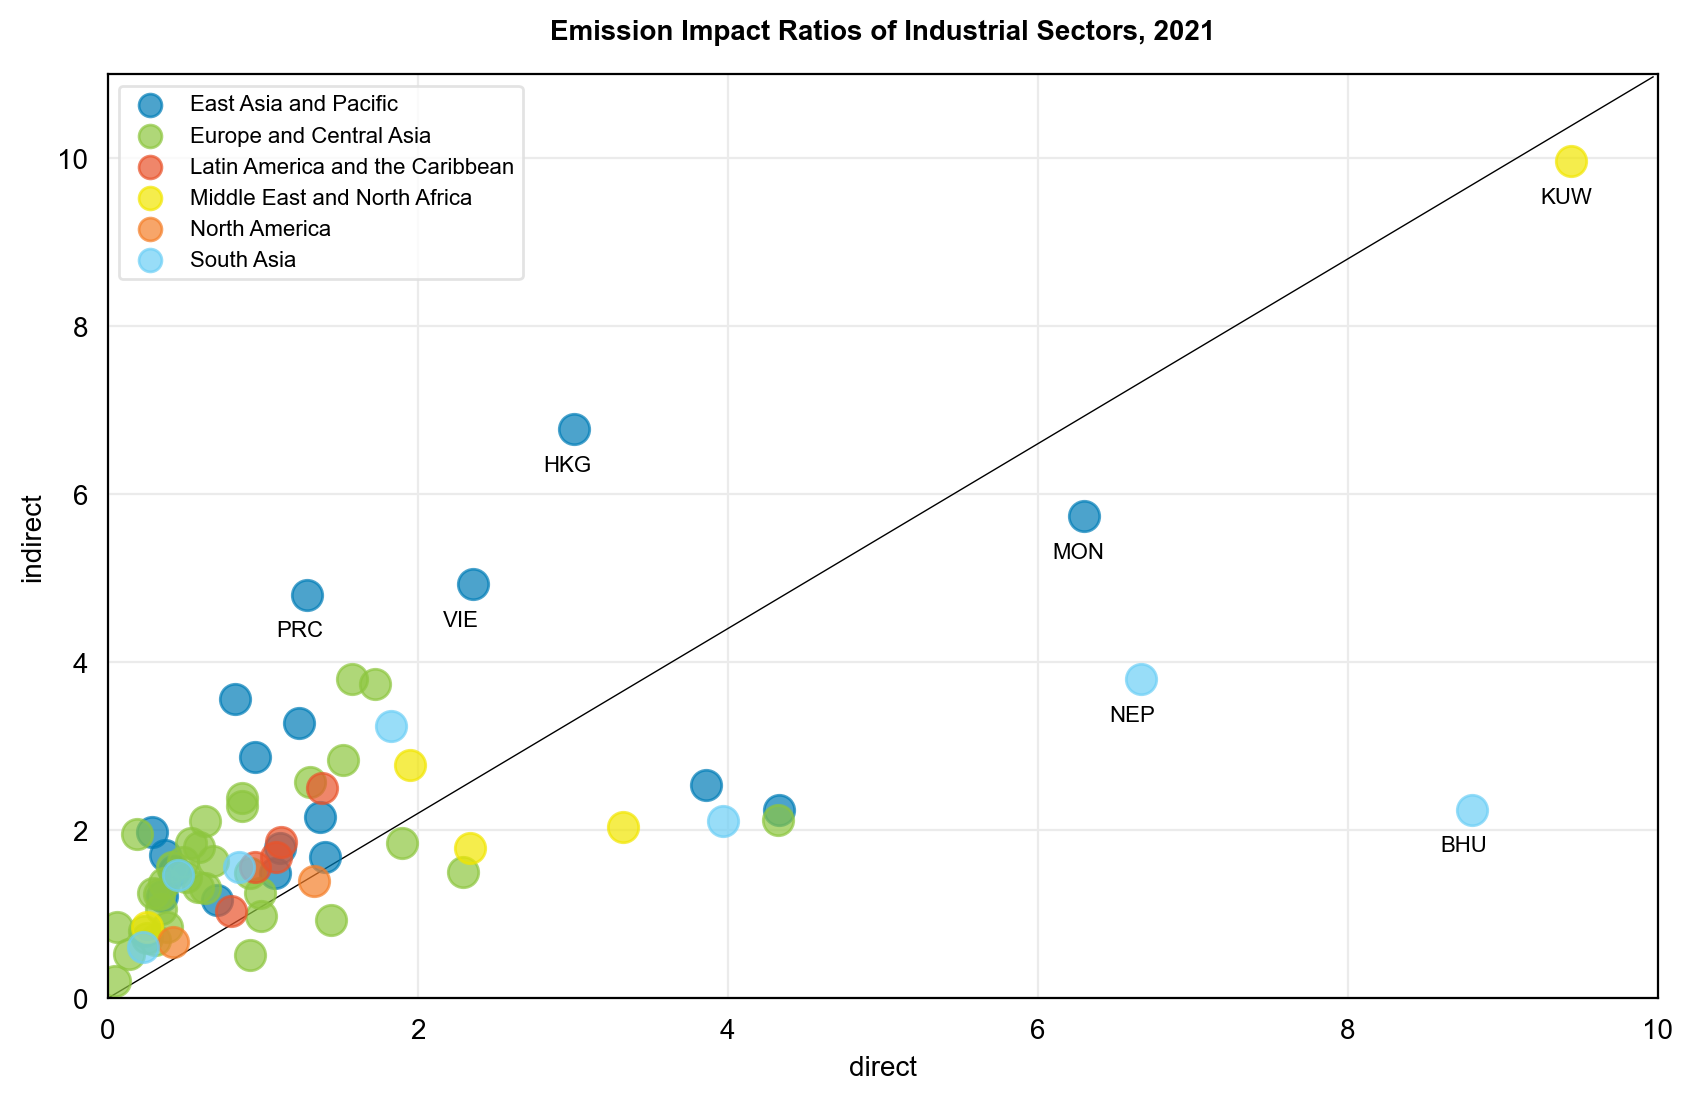

In [492]:
plt.figure(figsize=(10, 6), dpi=200, edgecolor='#EBEBEB')
plt.plot([0, eir_2021['i_eir'].max()], [0, eir_2021['i_eir'].max()+1], color='black', linewidth=0.5)
for region, color in region_colors.items():
    region_data = eir_2021[eir_2021['region'] == region]
    plt.scatter(x=region_data['d_eir'], 
                y=region_data['i_eir'], 
                c=color, s=120, alpha=0.7, 
                label=region, zorder=2)

for i, (x, y) in enumerate(zip(eir_2021.d_eir, eir_2021.i_eir)):
    if x > 6 or y > 4:
        plt.annotate(eir_2021.country.iloc[i], (x-0.2, y - 0.5), fontsize=8)

plt.grid(color='#EBEBEB') 
plt.xlim((0,10))
plt.ylim((0,11))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('direct', fontsize=10)
plt.ylabel('indirect', fontsize=10)
plt.title('Emission Impact Ratios of Industrial Sectors, 2021', y=1.02, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=8, markerscale=0.75, loc='upper left')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.show()

##### A.2 Country: EIR of industrial sectors, 2021

In [28]:
# EIR by country (Asia)
ei_asia = eir_2021[eir_2021['region'].isin(['East Asia and Pacific', 'Europe and Central Asia', 'South Asia'])]

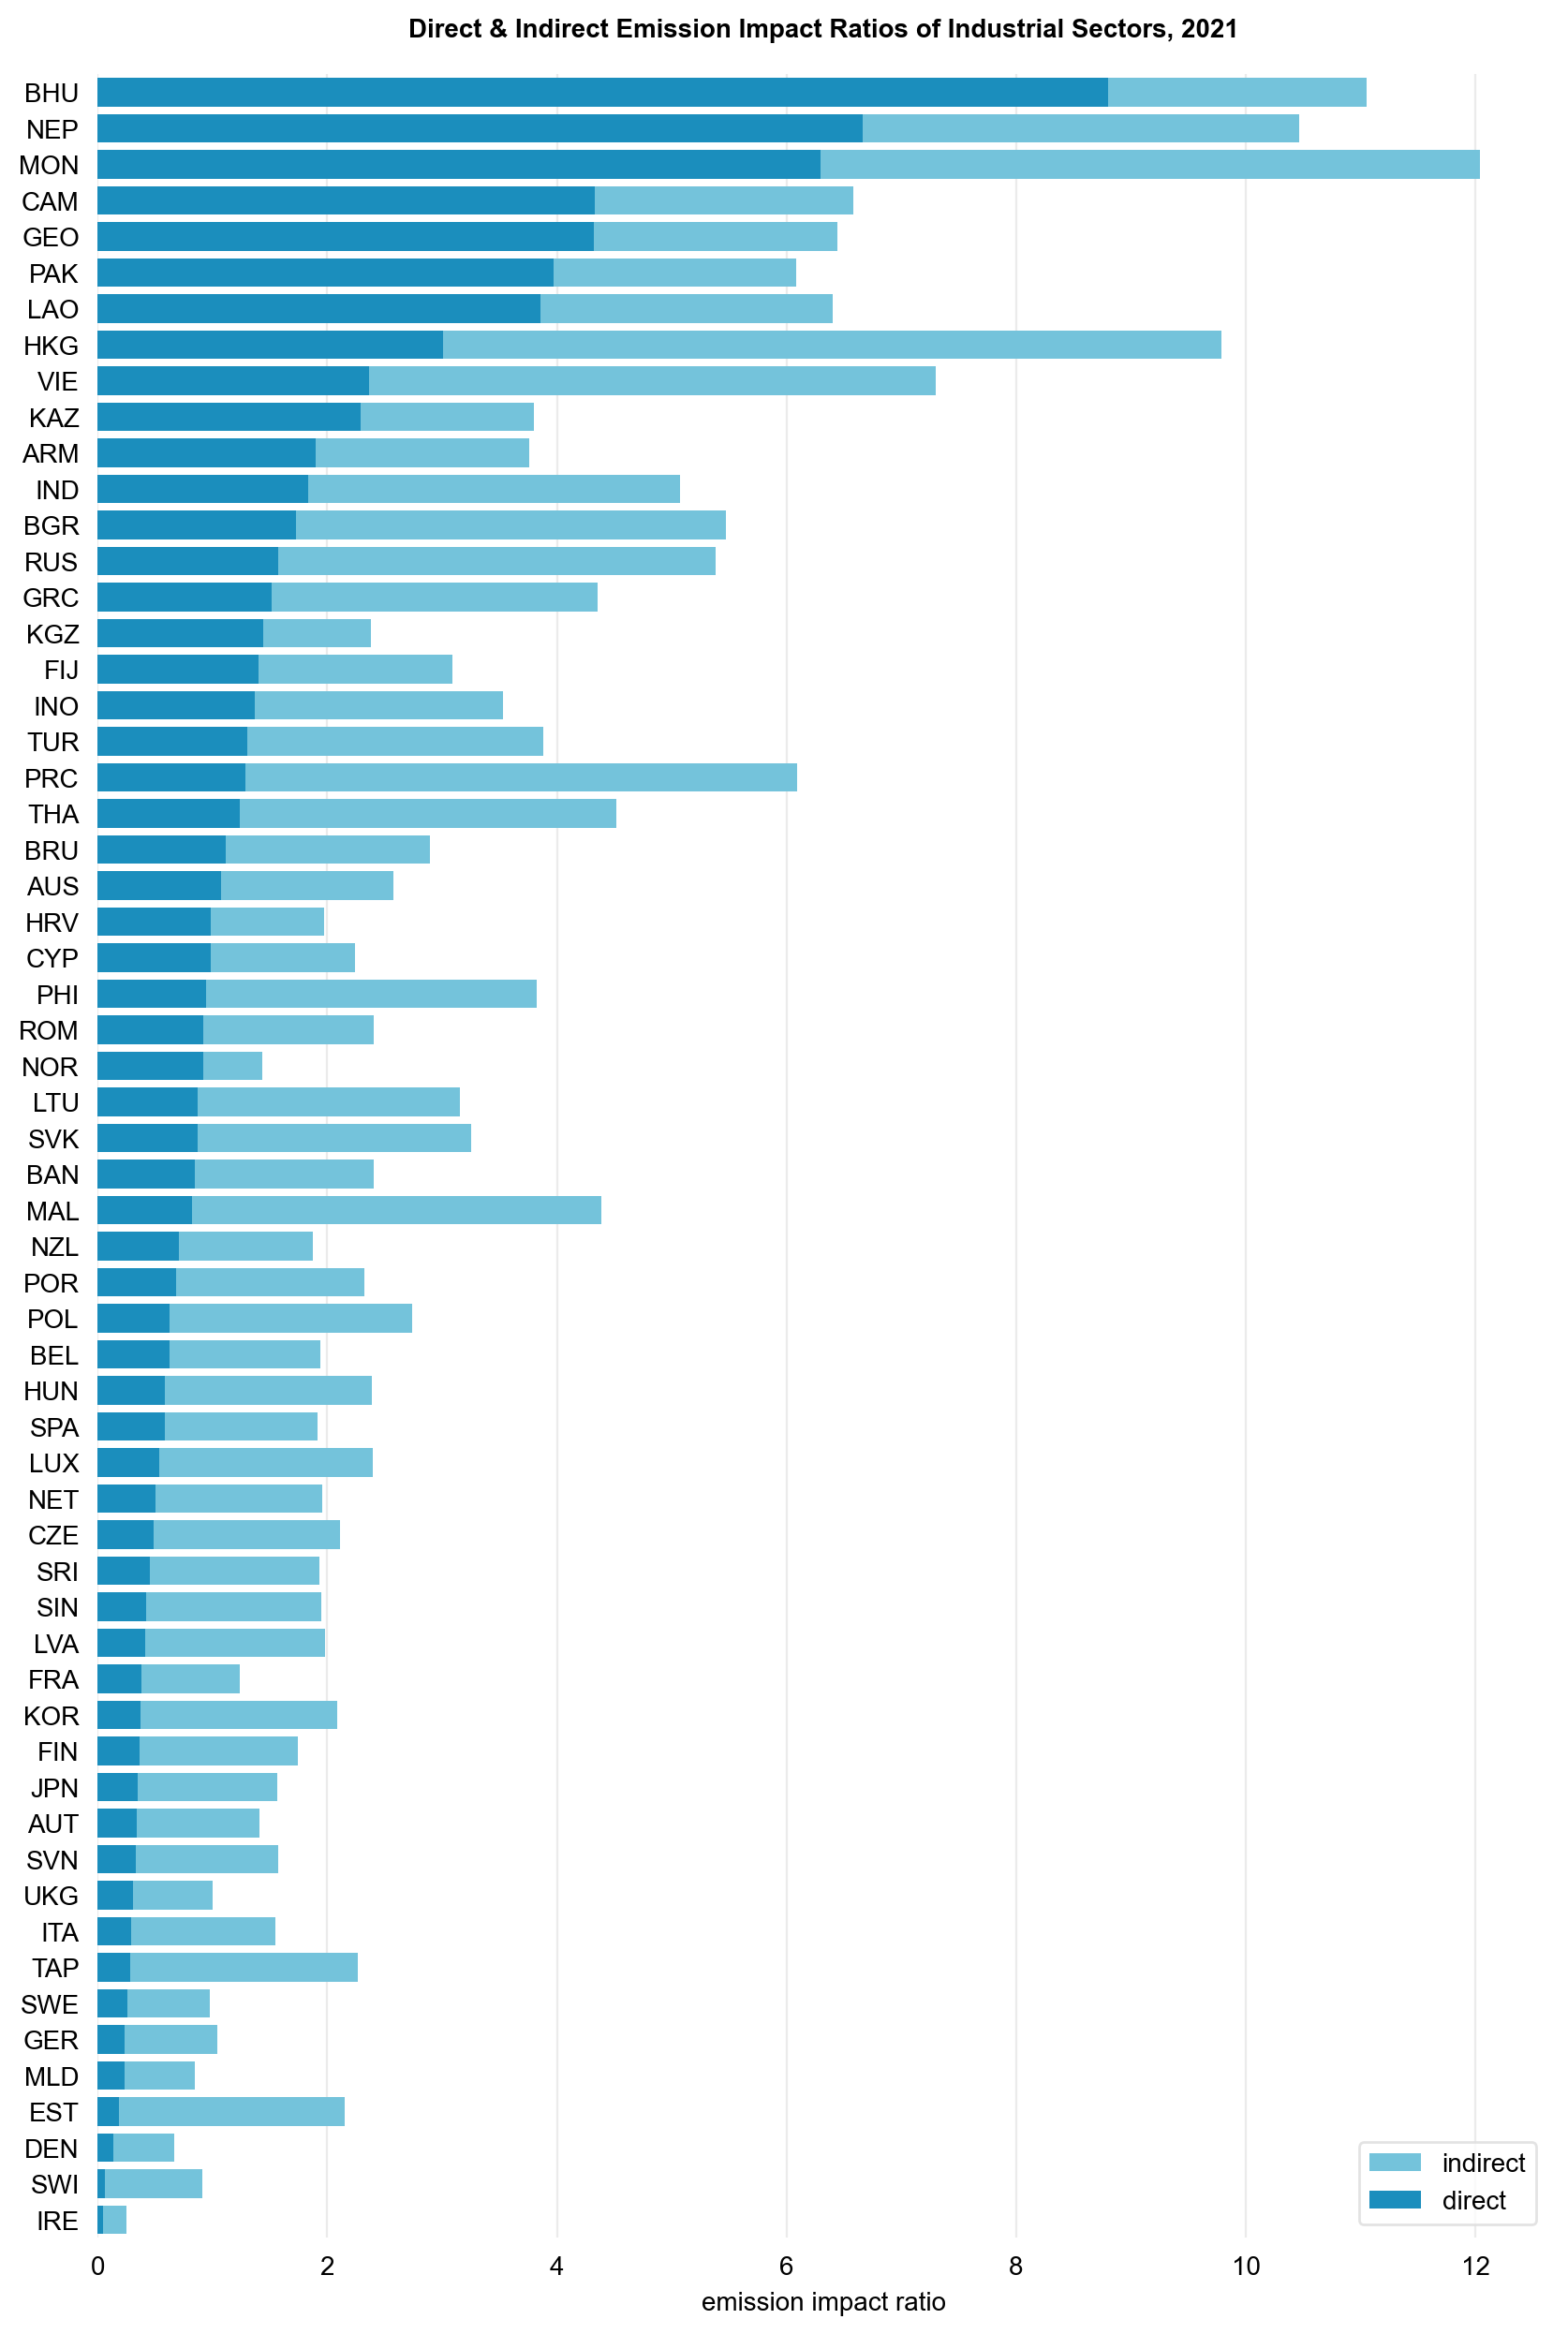

In [29]:
ordered_df = ei_asia.sort_values(by='d_eir', ascending=False)
left_positions = ordered_df["d_eir"].values

f, ax = plt.subplots(figsize=(10, 15), dpi=200)
sns.barplot(x="i_eir", y="country", data=ordered_df, label="indirect", 
            color="#63ccec", errorbar=None, left=left_positions, zorder=2)
sns.barplot(x="d_eir", y="country", data=ordered_df, label="direct", 
            color="#0099d8", errorbar=None, zorder=2)

plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('emission impact ratio', fontsize=10)
plt.ylabel('')
plt.title('Direct & Indirect Emission Impact Ratios of Industrial Sectors, 2021', y=1.01, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
sns.despine(left=True, bottom=True)

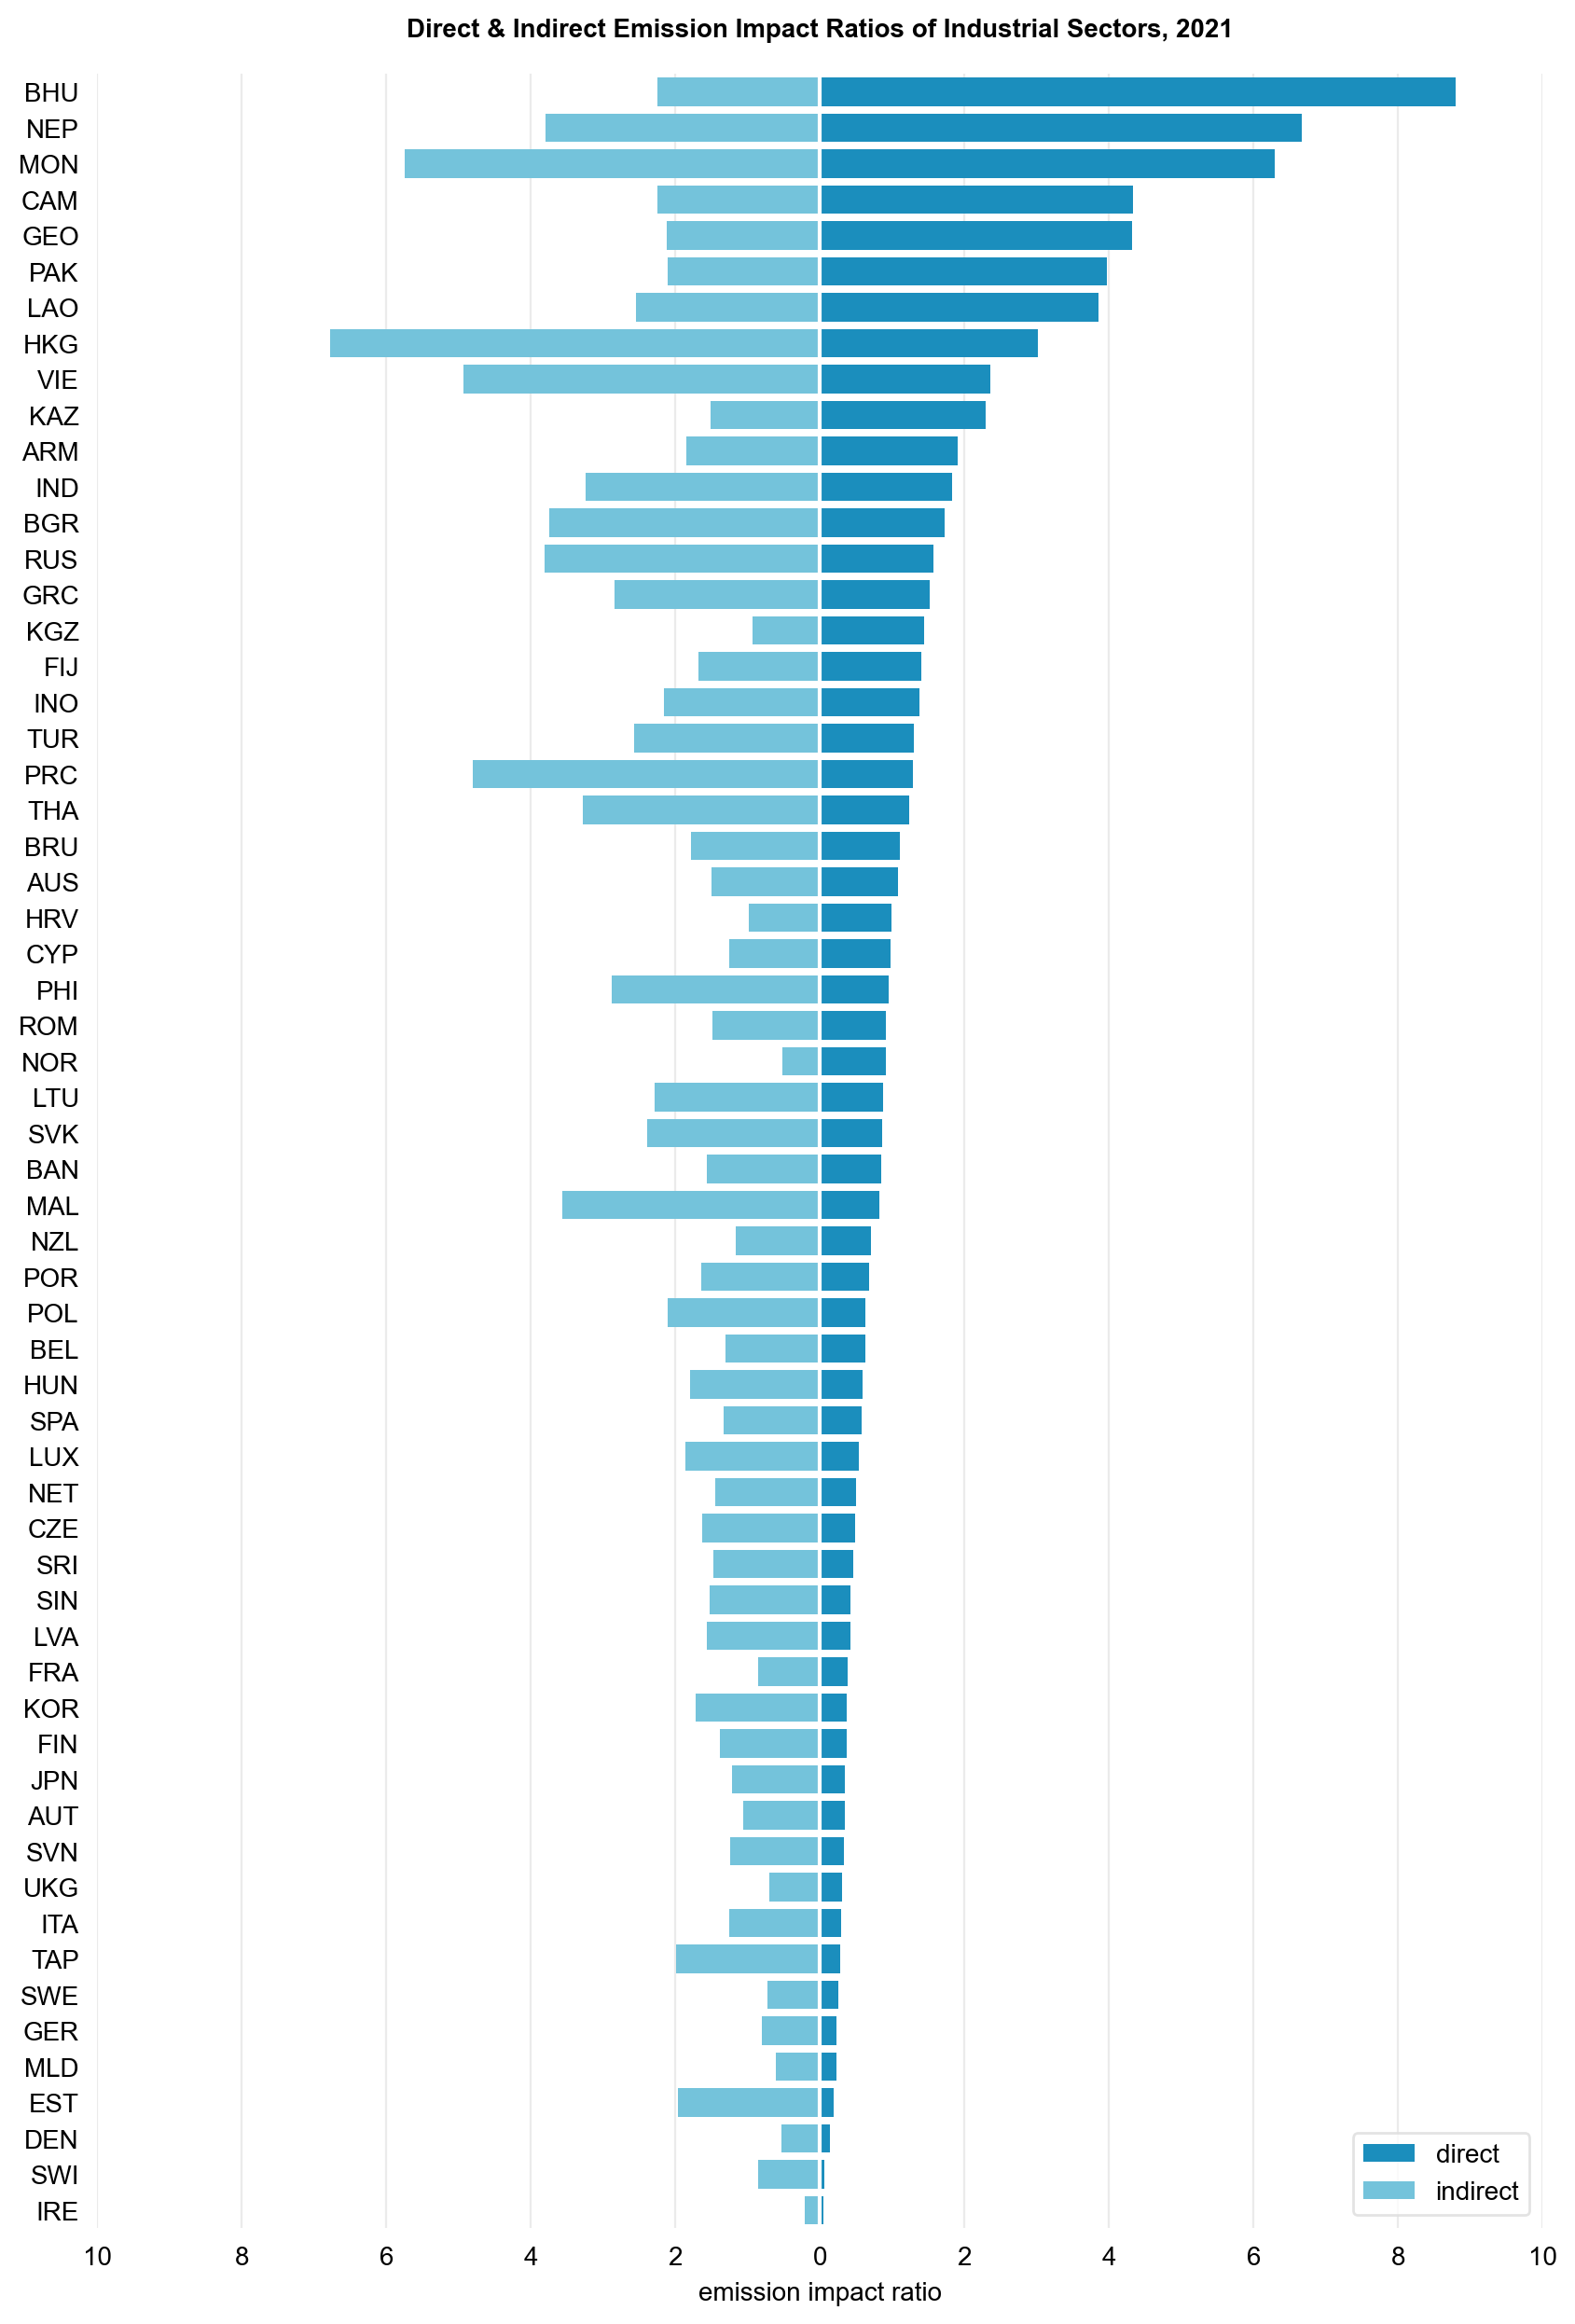

In [30]:
ordered_df = ei_asia.sort_values(by='d_eir', ascending=False)

positive_values = ordered_df["d_eir"].values
negative_values = -ordered_df["i_eir"].values

f, ax = plt.subplots(figsize=(10, 15), dpi=200)

sns.barplot(x=positive_values, y="country", data=ordered_df, color="#0099d8", label="direct", ax=ax, zorder=2)
sns.barplot(x=negative_values, y="country", data=ordered_df, color="#63ccec", label="indirect", ax=ax, zorder=2)

plt.axvline(x=0, color='white')
plt.grid(axis='x', color='#EBEBEB') 
xticks = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
xticklabels = [f"{abs(val):.0f}" for val in xticks]
plt.xticks(xticks, xticklabels, fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('emission impact ratio', fontsize=10)
plt.ylabel('')
plt.title('Direct & Indirect Emission Impact Ratios of Industrial Sectors, 2021', y=1.01, fontsize=10, fontweight='bold')

legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')

sns.despine(left=True, bottom=True)
plt.show()


##### A.3 Country: EIR 2017, 2019, 2021

In [31]:
eir_total = eir_agg[['country', 'year', 'region', 'd_eir', 'i_eir', 'eir']]
eir_total = eir_total[(eir_total['year'].isin([2017, 2019,2021])) & 
                    (eir_total['region'] == 'East Asia and Pacific')]
eir_total = eir_total.pivot(index=['country', 'region'], columns='year', values='eir').reset_index()

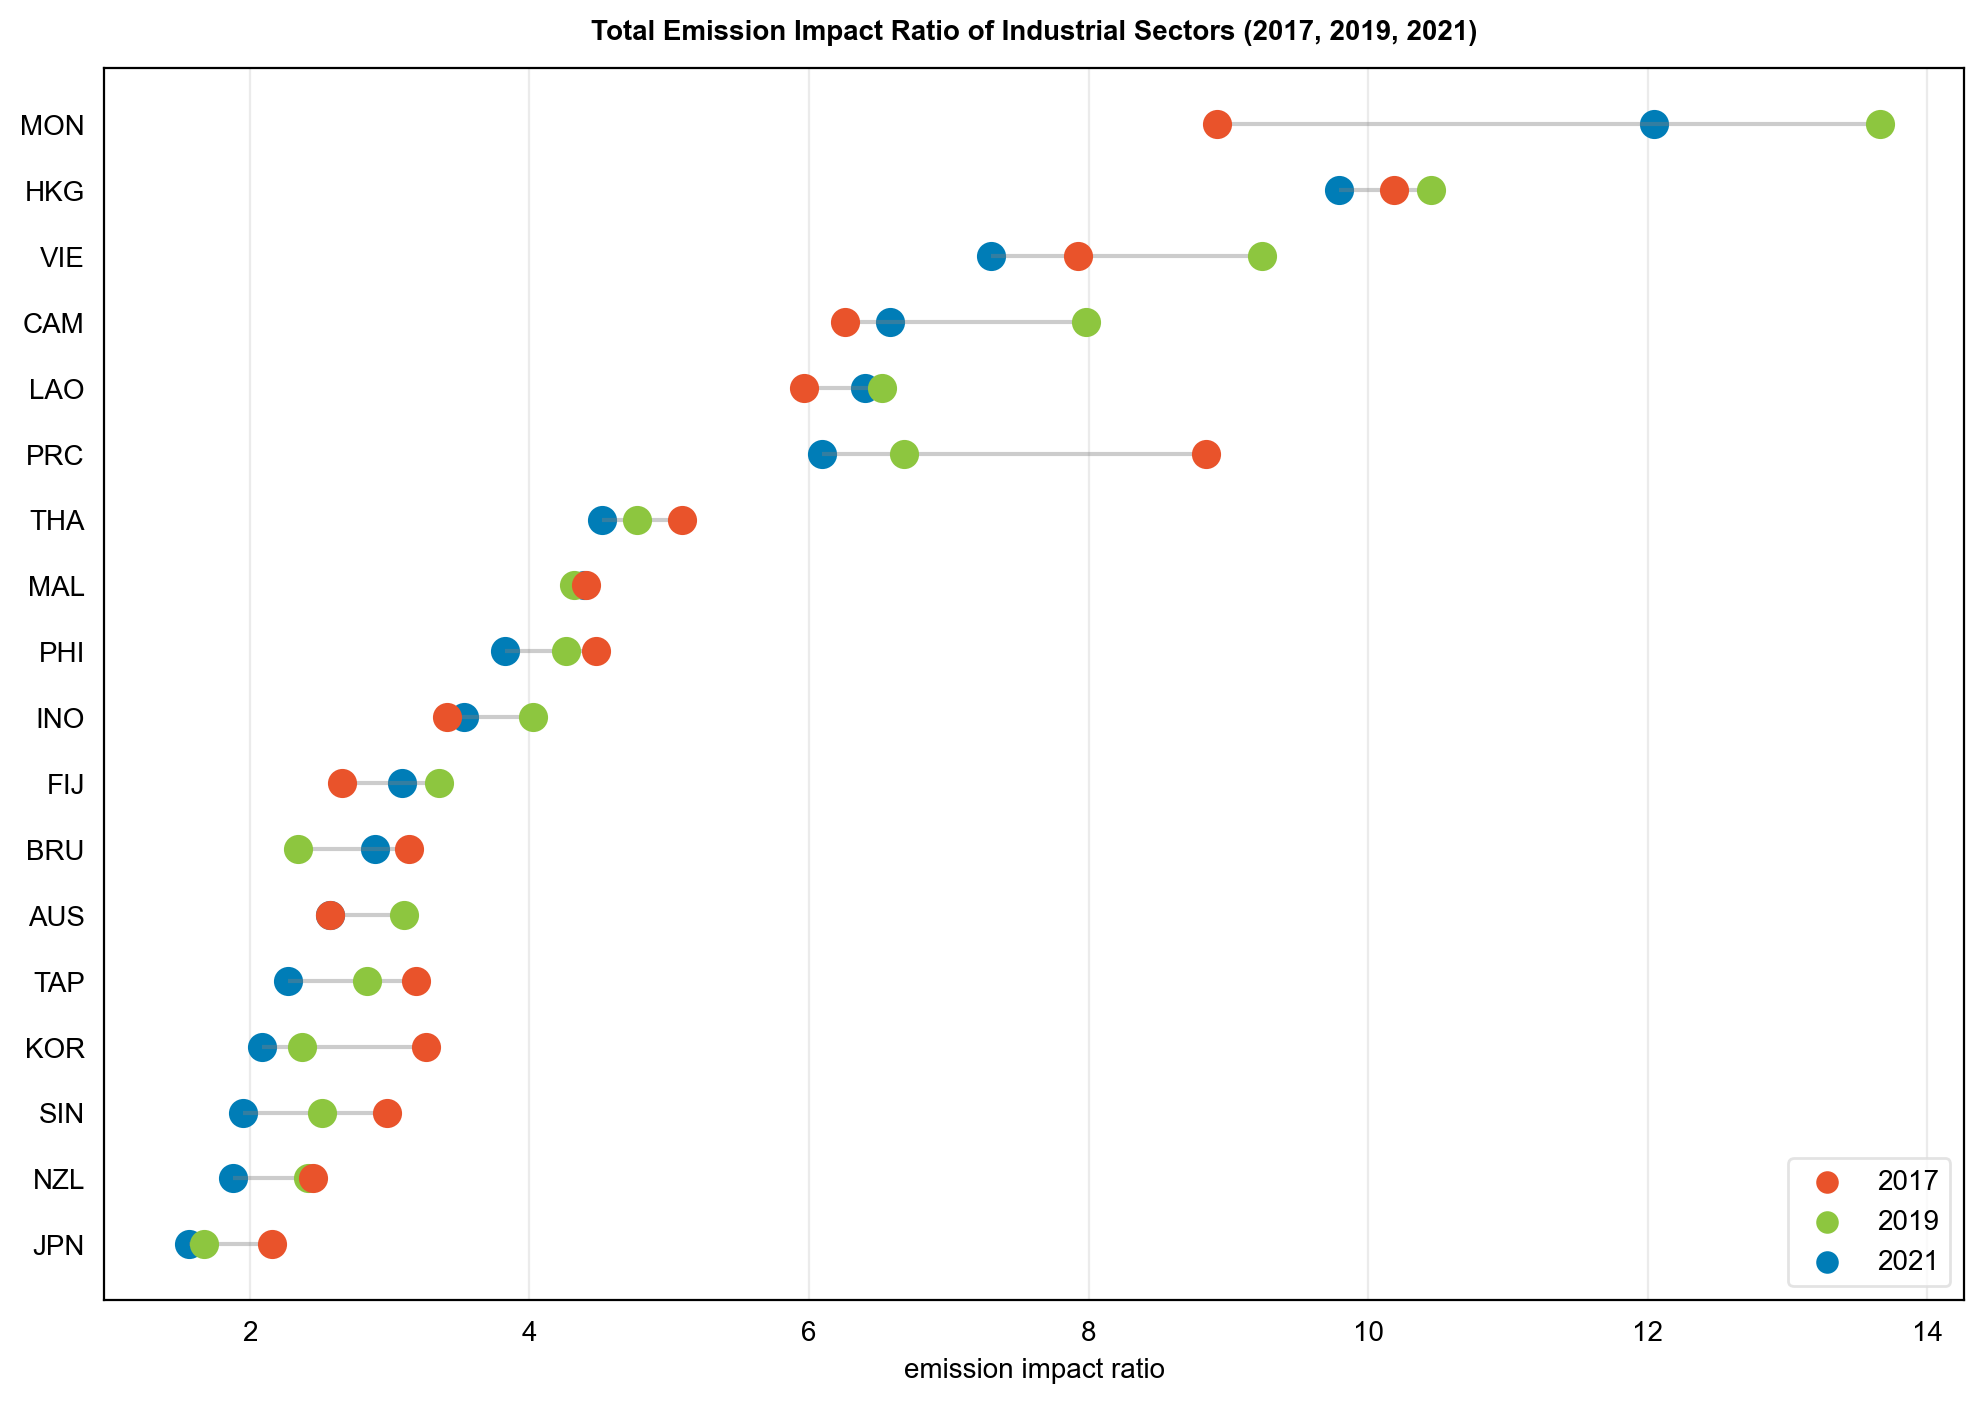

In [237]:
ordered_df = eir_total.sort_values(by=2021)

plt.figure(figsize=(12, 8), dpi=200, edgecolor='#EBEBEB')

plt.scatter(x=ordered_df[2017], y=ordered_df['country'], color='#e9532b', alpha=1, label='2017', s=90, zorder=4)
plt.scatter(x=ordered_df[2019], y=ordered_df['country'], color='#8dc63f', alpha=1, label='2019', s=90, zorder=3)
plt.scatter(x=ordered_df[2021], y=ordered_df['country'], color='#007db7', alpha=1, label='2021', s=90, zorder=2)

min_val = ordered_df[[2017, 2019, 2021]].min(axis=1)
max_val = ordered_df[[2017, 2019, 2021]].max(axis=1)
plt.hlines(y=ordered_df['country'], xmin=min_val, xmax=max_val, color='grey', alpha=0.4)

plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('emission impact ratio', fontsize=10, y=-1.01)
plt.ylabel('')
plt.title('Total Emission Impact Ratio of Industrial Sectors (2017, 2019, 2021)', y=1.01, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=10, markerscale=0.75, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.show()

##### A.4 Sector: EIR by industrial sector

In [239]:
eir_sector = industry_df[industry_df['gva'] >0]
eir_sector = (
    eir_sector[['mrio_sector', 'sector_name', 'sector_name_short', 'year', 'd_eir', 'i_eir', 'eir']]
    .groupby(['mrio_sector', 'sector_name', 'sector_name_short', 'year']).agg('mean').reset_index()
    )

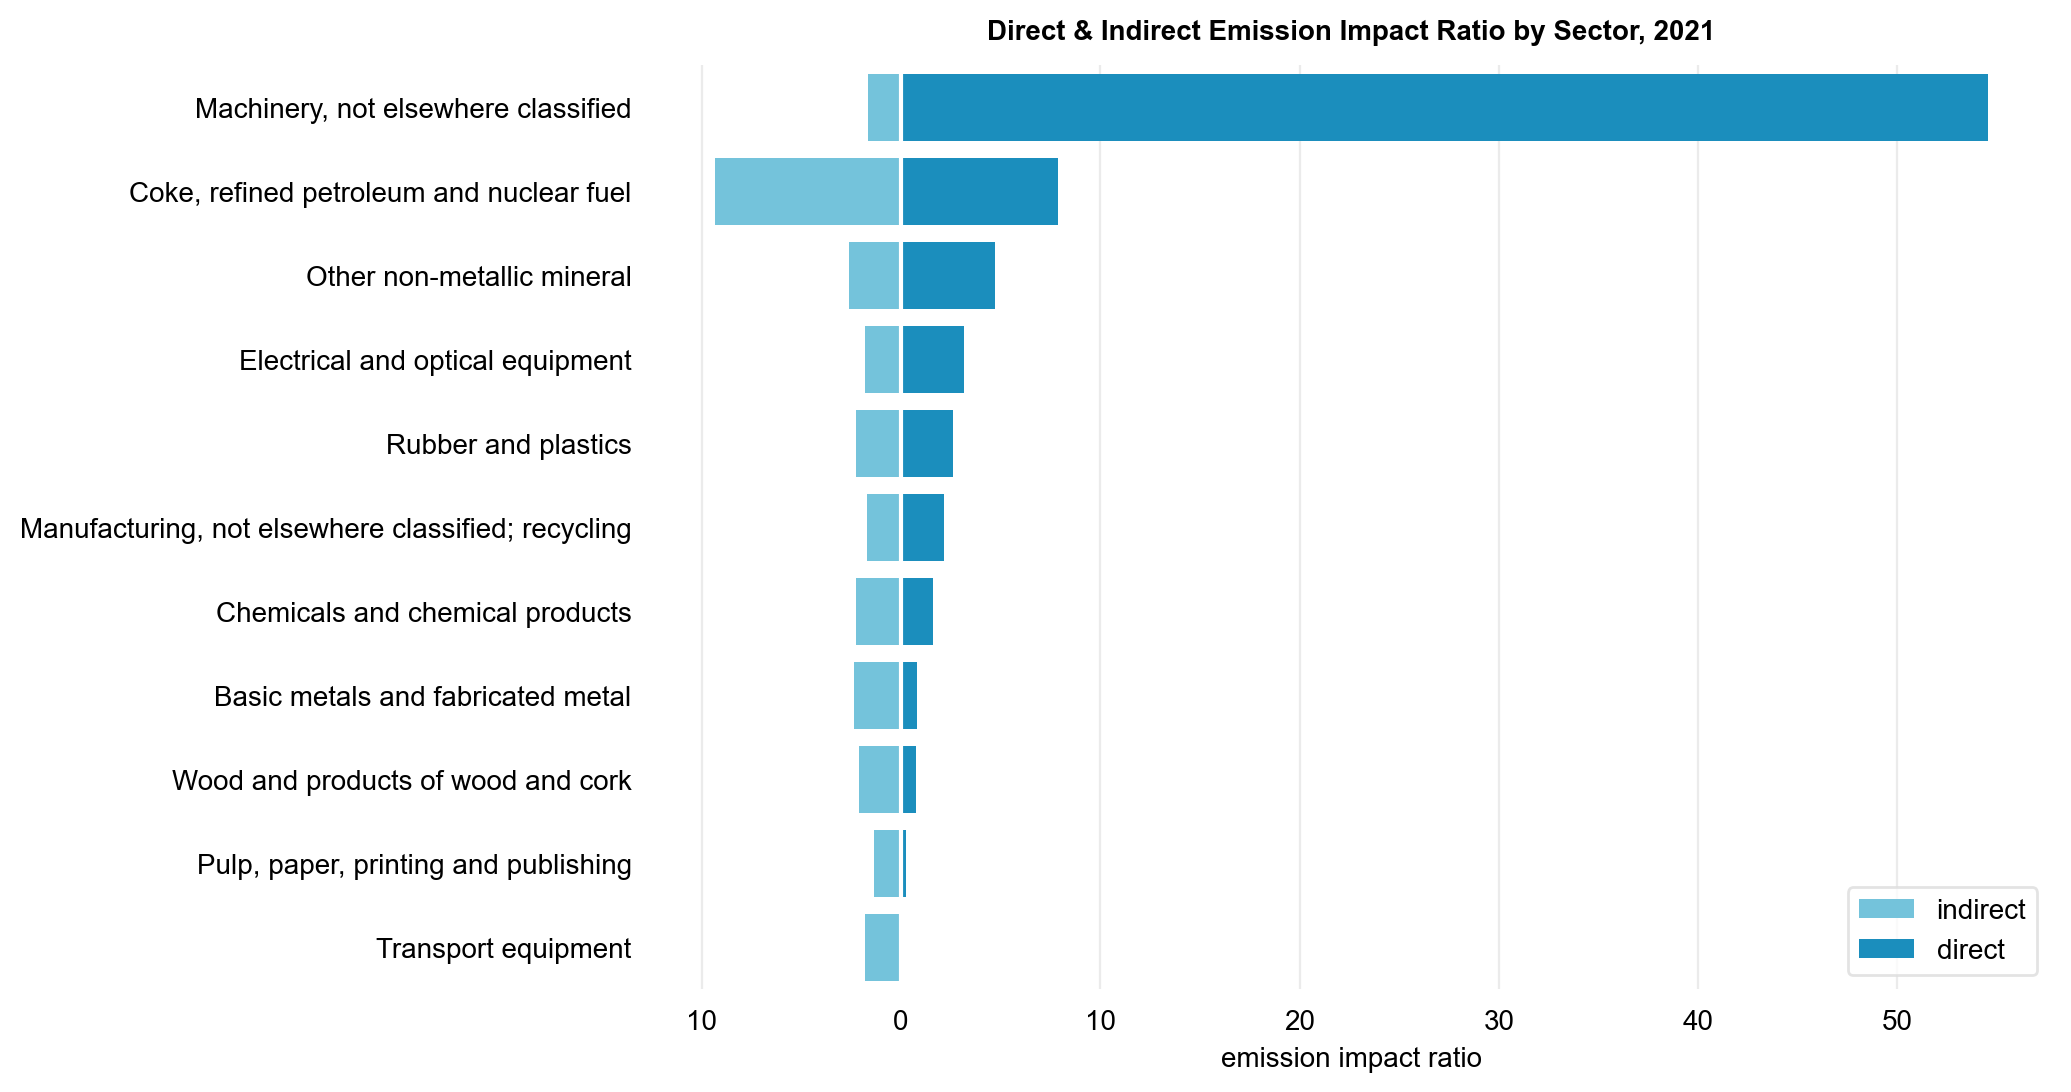

In [167]:
ordered_df = (
    eir_sector[(eir_sector['year'] == 2021)]
    .sort_values(by='d_eir', ascending=False)
)

positive_values = ordered_df["d_eir"].values
negative_values = -ordered_df["i_eir"].values

f, ax = plt.subplots(figsize=(10, 6), dpi=200)

sns.barplot(x=negative_values, y="sector_name", data=ordered_df, color="#63ccec", label="indirect", ax=ax, zorder=2)
sns.barplot(x=positive_values, y="sector_name", data=ordered_df, color="#0099d8", label="direct", ax=ax, zorder=2)

plt.axvline(x=0, color='white')
plt.grid(axis='x', color='#EBEBEB') 

xticks = [-10, 0, 10, 20, 30, 40, 50]
xticklabels = [f"{abs(val):.0f}" for val in xticks]
plt.xticks(xticks, xticklabels, fontsize=10)
ax.set_yticks(np.arange(len(ordered_df)))
plt.yticks(fontsize=10)

plt.tick_params(left=False, bottom=False) 
plt.xlabel('emission impact ratio', fontsize=10)
plt.ylabel('')
plt.title('Direct & Indirect Emission Impact Ratio by Sector, 2021', y=1.01, fontsize=10, fontweight='bold')
plt.subplots_adjust(left=0.2)

legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')

sns.despine(left=True, bottom=True)

##### A.5 Sector: EIR by IPCC sector

In [275]:
eir_ipcc = em_df_sector[em_df_sector['gva'] >0]
eir_ipcc = (
    eir_ipcc[['sector_no', 'mrio_sector', 'sector_name', 'sector_name_short', 'ipcc_sector', 'year', 'd_eir', 'i_eir', 'eir']]
    .groupby(['sector_no', 'mrio_sector', 'sector_name', 'sector_name_short', 'ipcc_sector', 'year']).agg('mean').reset_index()
    )

In [282]:
df_heatmap = (
    eir_ipcc[(eir_ipcc['year'] == 2021) & (eir_ipcc['mrio_sector'].isin(ind_sectors))].copy()
    .pivot_table(values='eir',index=['sector_no', 'sector_name'],columns='ipcc_sector',aggfunc='mean')
    .reset_index()
    .sort_values(by='sector_no')
)

In [288]:
df_heatmap = (
    eir_ipcc[(eir_ipcc['year'] == 2021) & (eir_ipcc['mrio_sector'].isin(ind_sectors))].copy()
    .pivot_table(values='eir',index=['sector_no', 'sector_name'],columns='ipcc_sector',aggfunc='mean')
    .sort_values(by='sector_no')
)

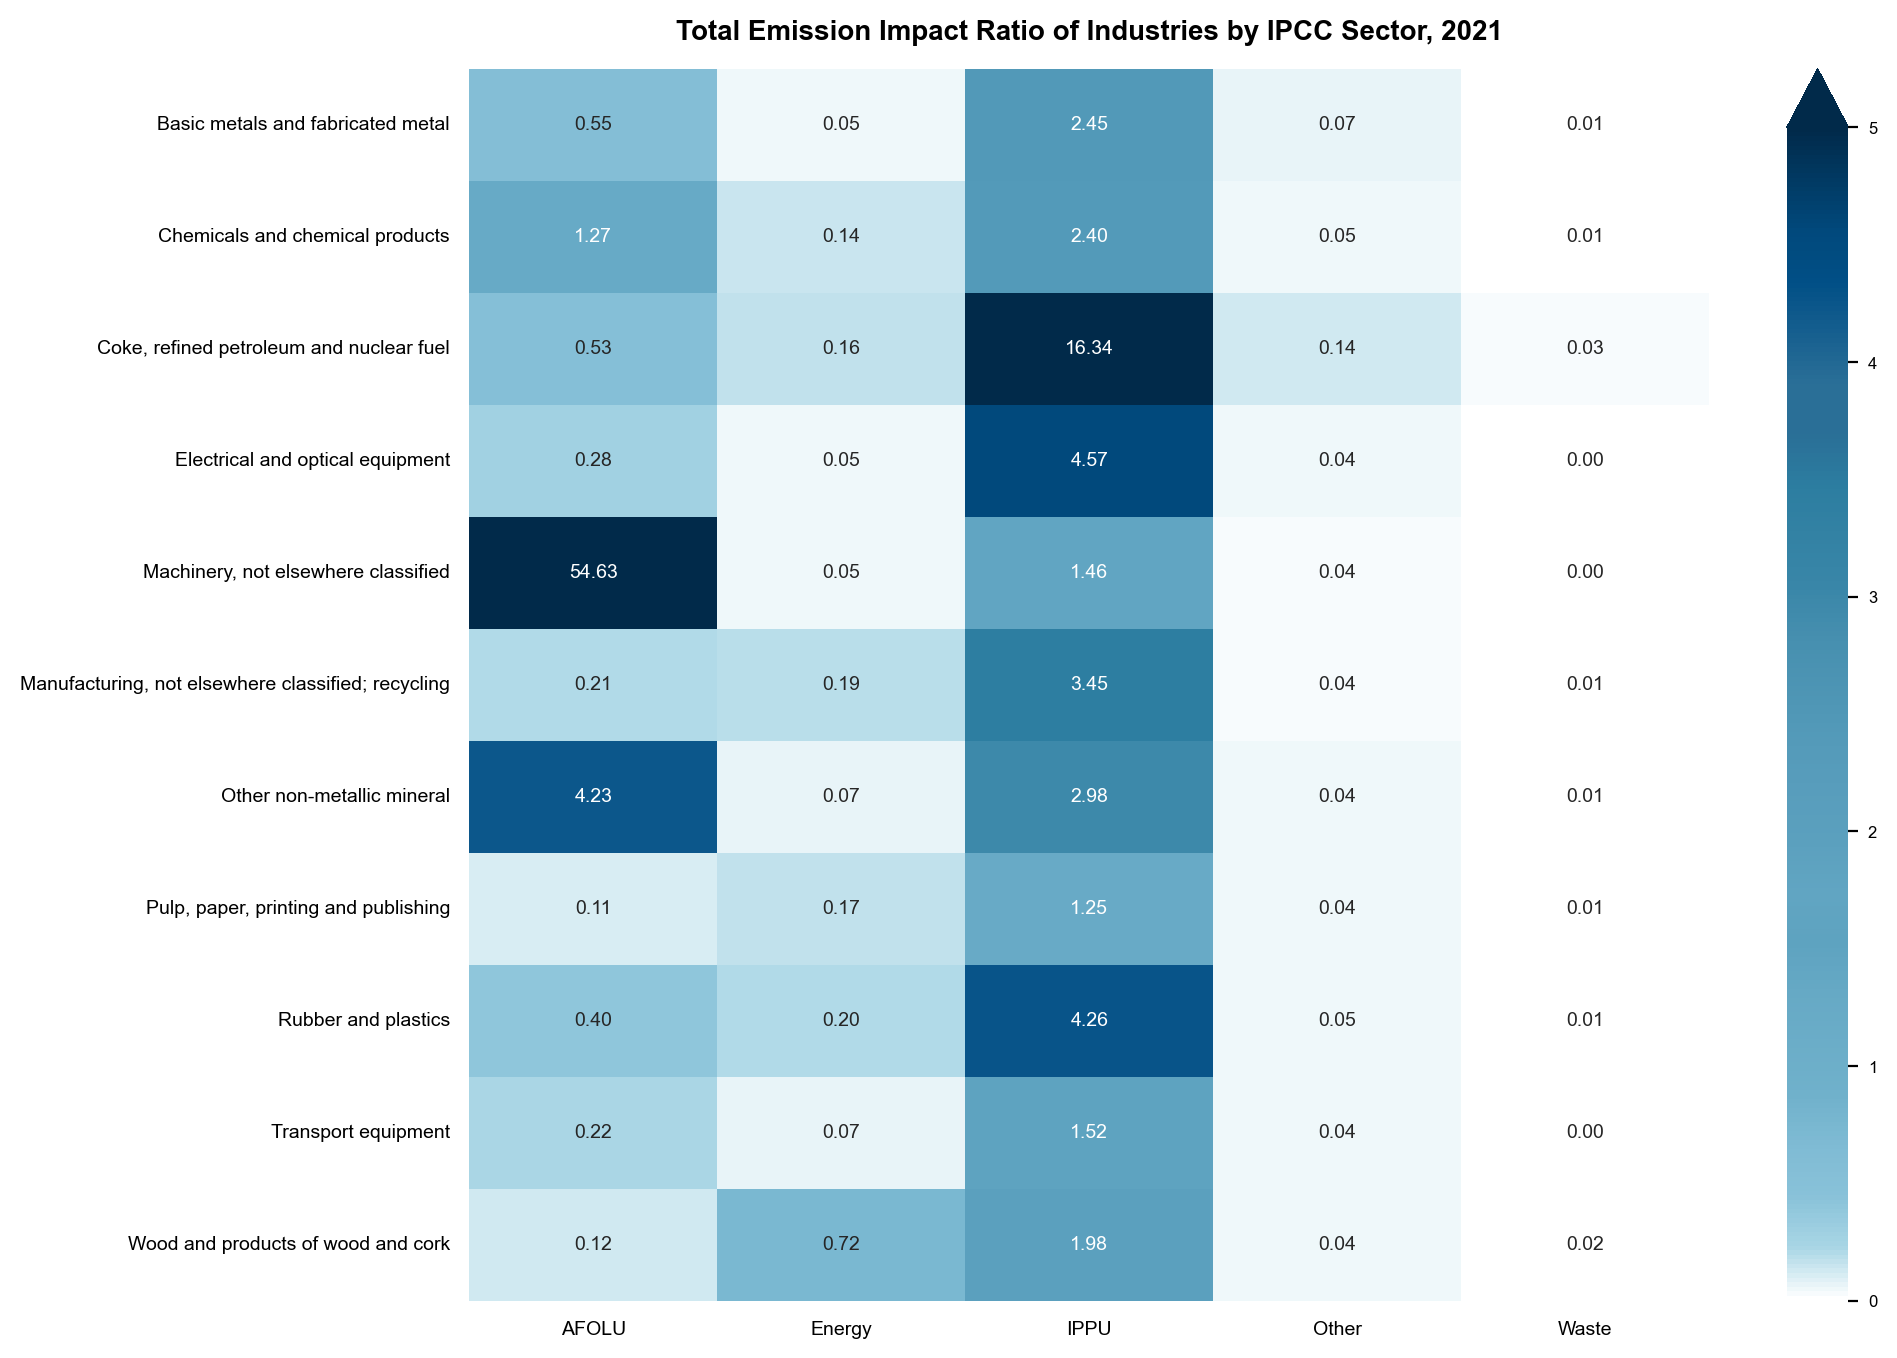

In [292]:
df_heatmap = (
    eir_ipcc[(eir_ipcc['year'] == 2021) & (eir_ipcc['mrio_sector'].isin(ind_sectors))].copy()
    .pivot_table(values='eir',index=['sector_name'],columns='ipcc_sector',aggfunc='mean')
)

f, ax = plt.subplots(figsize=(10, 8), dpi=200)

def custom_annot(val):
    return '-' if val == 0 else f'{val:.2f}'
annot_df = df_heatmap.map(custom_annot)

# color palette
heatmap_colors = ['#FFFFFF', '#A9D6E5', '#89C2D9', '#7FBBD4', '#70B1CB', '#6BADC8', '#66A9C5', '#5EA3C0', 
                  '#61A5C2', '#5BA0BE', '#589DBC', '#549AB9', '#4D95B4', '#468FAF', '#3986A8', '#3382A4', 
                  '#2C7DA0', '#2A6F97', '#2A6F97', '#165F8F', '#014F86', '#01497C', '#013A63', '#012A4A']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', heatmap_colors)

sns.heatmap(df_heatmap,annot=annot_df, cmap=custom_cmap, fmt='', vmin=0, vmax=5, ax=ax,
            cbar_kws={'extend': 'max', 'spacing': 'proportional'}, annot_kws={"fontsize": 7})

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)

plt.tick_params(left=False, bottom=False)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('')
plt.ylabel('')
plt.title('Total Emission Impact Ratio of Industries by IPCC Sector, 2021', y=1.01, fontsize=10, fontweight='bold')
plt.show()

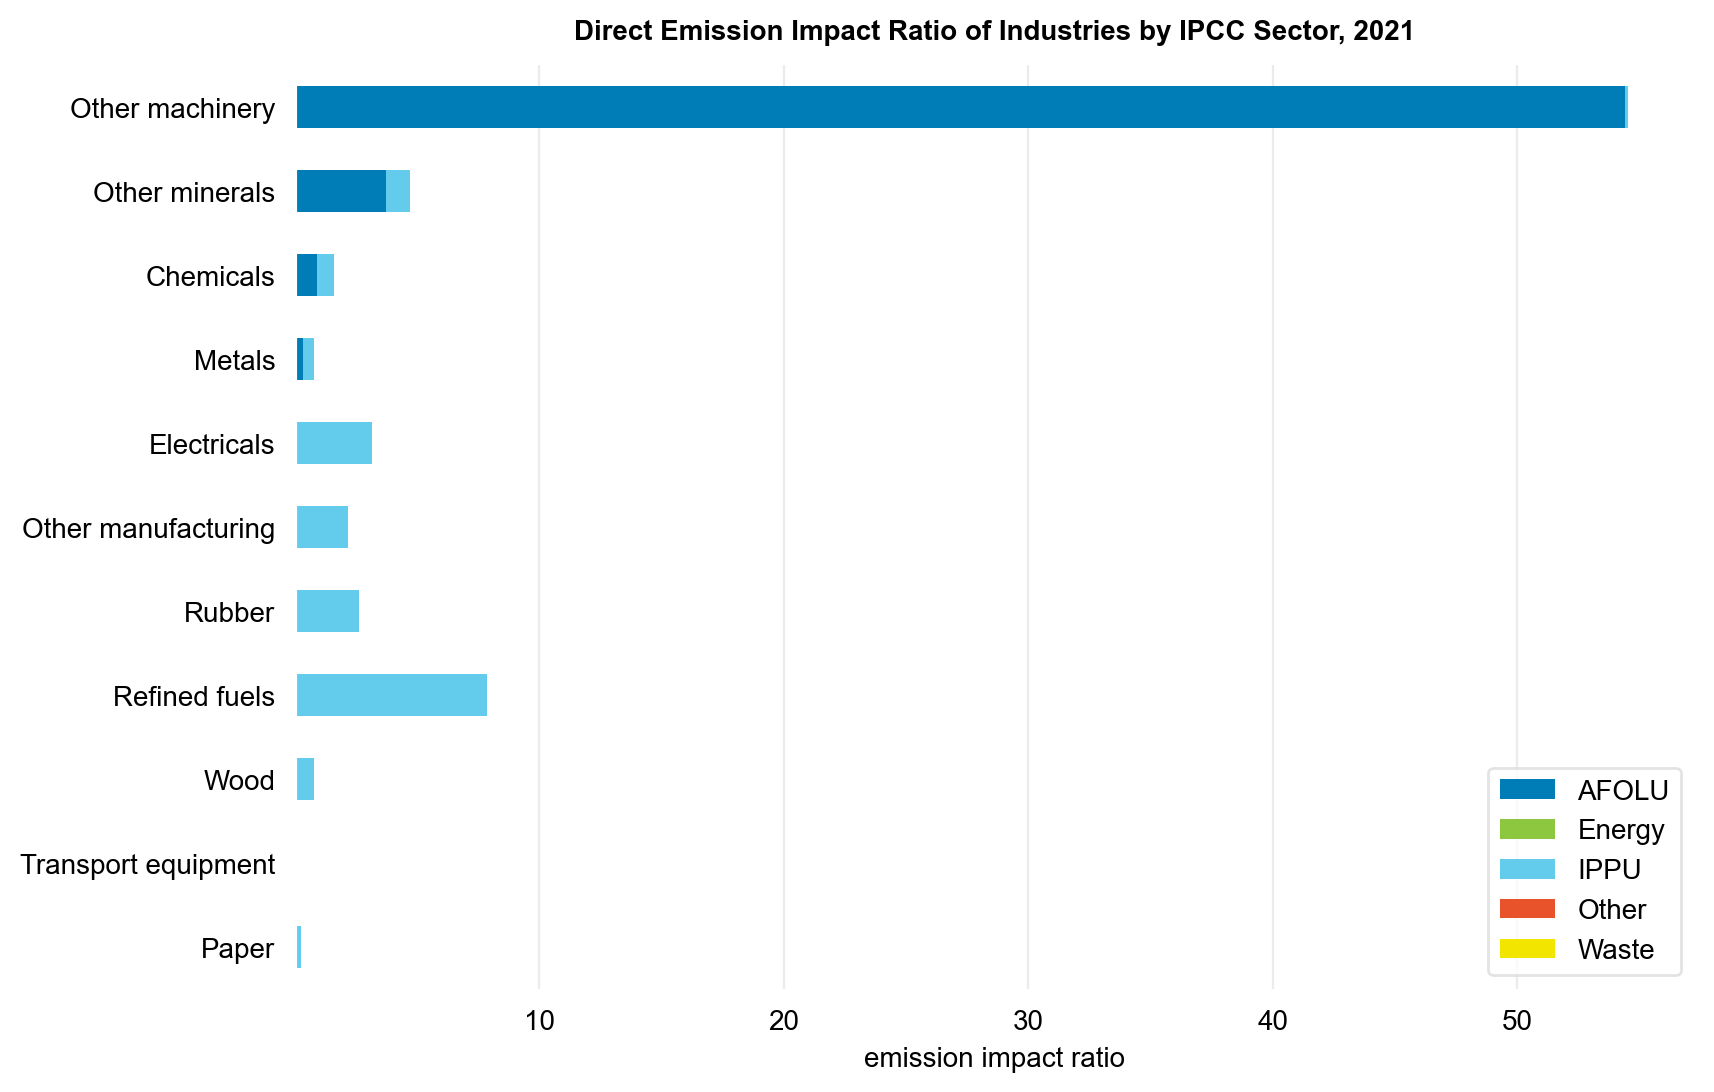

In [212]:
df = (
    eir_ipcc[['sector_name_short', 'ipcc_sector', 'd_eir']]
    [(eir_ipcc['year'] == 2021) & (eir_ipcc['mrio_sector'].isin(ind_sectors))].copy()
    .pivot_table(values='d_eir',index='sector_name_short', columns='ipcc_sector')   
    .sort_values(by='AFOLU', ascending=True)
)

f, ax = plt.subplots(figsize=(10, 6), dpi=200)

df.plot(kind='barh', stacked=True, color=['#007db7', '#8dc63f', '#63ccec', '#e9532b', '#f2e600'], ax=ax, zorder=2)

plt.axvline(x=0, color='white')
plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('emission impact ratio', fontsize=10)
plt.ylabel('')
plt.title('Direct Emission Impact Ratio of Industries by IPCC Sector, 2021', y=1.01, fontsize=10, fontweight='bold')
plt.subplots_adjust(left=0.2)
 
legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')

sns.despine(left=True, bottom=True)

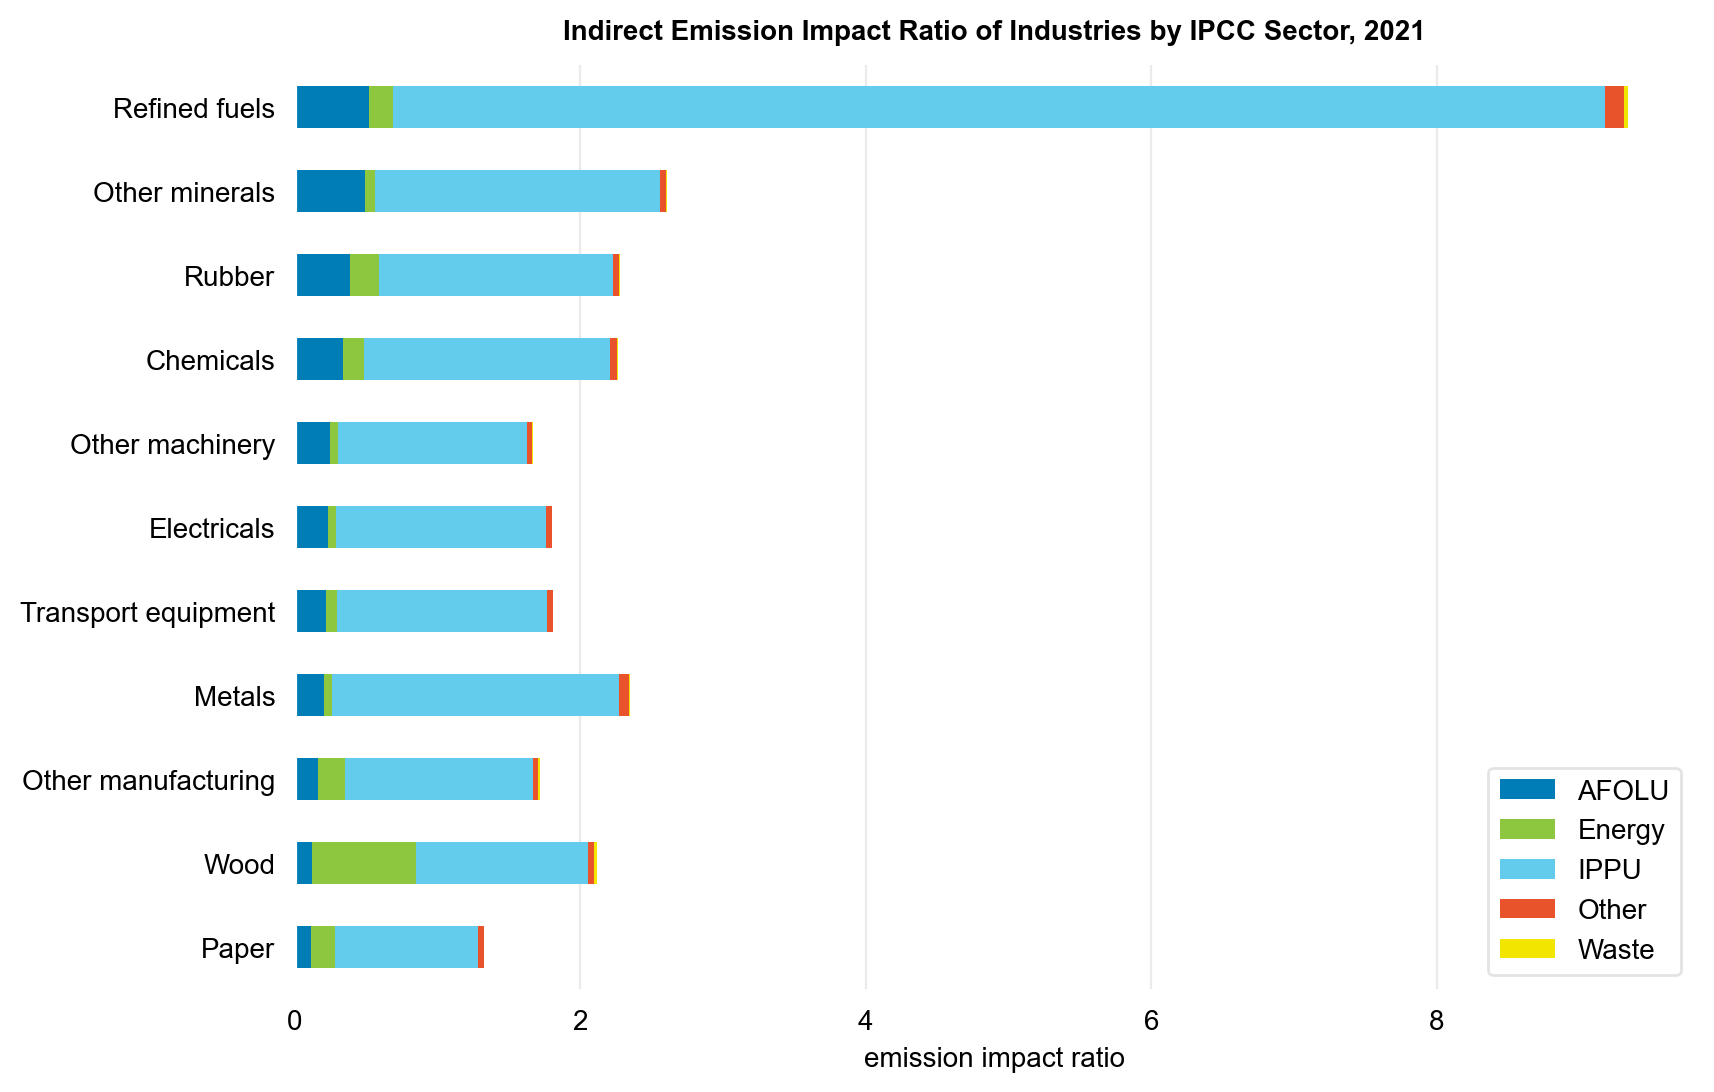

In [211]:
df = (
    eir_ipcc[['sector_name_short', 'ipcc_sector', 'i_eir']]
    [(eir_ipcc['year'] == 2021) & (eir_ipcc['mrio_sector'].isin(ind_sectors))].copy()
    .pivot_table(values='i_eir',index='sector_name_short', columns='ipcc_sector')   
    .sort_values(by='AFOLU', ascending=True)
)

f, ax = plt.subplots(figsize=(10, 6), dpi=200)

df.plot(kind='barh', stacked=True, color=['#007db7', '#8dc63f', '#63ccec', '#e9532b', '#f2e600'], ax=ax, zorder=2)

plt.axvline(x=0, color='white')
plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('emission impact ratio', fontsize=10)
plt.ylabel('')
plt.title('Indirect Emission Impact Ratio of Industries by IPCC Sector, 2021', y=1.01, fontsize=10, fontweight='bold')
plt.subplots_adjust(left=0.2)
 
legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')

sns.despine(left=True, bottom=True)

##### A.6 Sector: EIR 2017, 2019, 2021

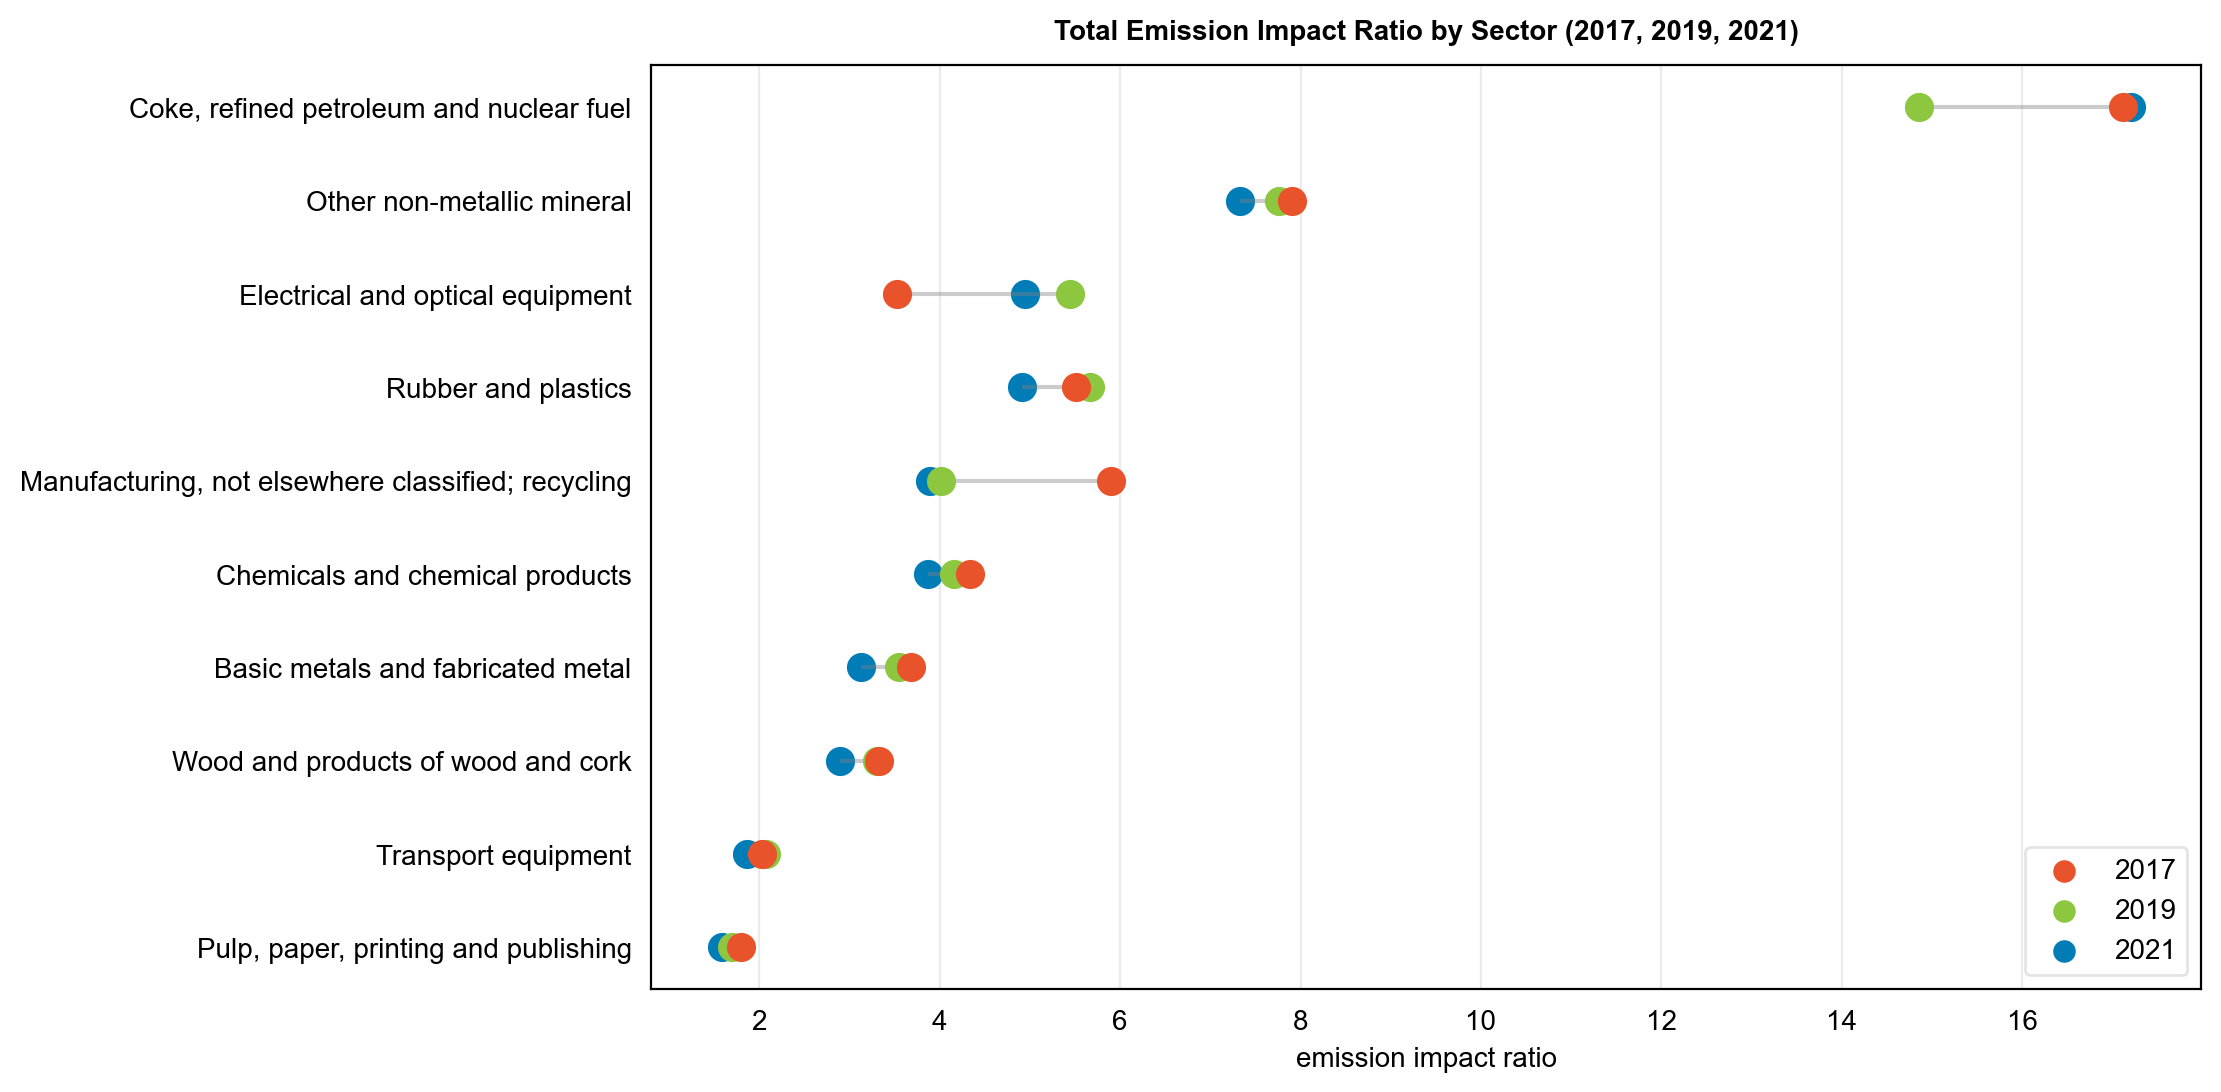

In [295]:
ordered_df = (
    eir_sector[(eir_sector['year'].isin([2017, 2019, 2021])) & (eir_sector['mrio_sector'] != 'c13')]
    .pivot(index=['sector_name', 'sector_name_short'], columns='year', values='eir').reset_index()
    .sort_values(by=2021)
)

plt.figure(figsize=(10, 6), dpi=200, edgecolor='#EBEBEB')

plt.scatter(x=ordered_df[2017], y=ordered_df['sector_name'], color='#e9532b', alpha=1, label='2017', s=90, zorder=4)
plt.scatter(x=ordered_df[2019], y=ordered_df['sector_name'], color='#8dc63f', alpha=1, label='2019', s=90, zorder=3)
plt.scatter(x=ordered_df[2021], y=ordered_df['sector_name'], color='#007db7', alpha=1, label='2021', s=90, zorder=2)

min_val = ordered_df[[2017, 2019, 2021]].min(axis=1)
max_val = ordered_df[[2017, 2019, 2021]].max(axis=1)
plt.hlines(y=ordered_df['sector_name'], xmin=min_val, xmax=max_val, color='grey', alpha=0.4)

plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False)
plt.xlabel('emission impact ratio', fontsize=10, y=-1.01)
plt.ylabel('')
plt.title('Total Emission Impact Ratio by Sector (2017, 2019, 2021)', y=1.01, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=10, markerscale=0.75, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
plt.show()

### B. Trade Exposure (TE)
Value of international trade (imports + exports) / value of domestic market (domestic production + imports)
- More global market exposure or presence the more likely it is that there will be foreign subtitute to a sector's product

In [410]:
# process trade data
def get_tedf():

    dfs = []
    for year in years: 
        data_mrio = mrio.MRIO(f'{input_mrio}', year, full=True)

        trade_matrix = data_mrio.Z.zeroout()
        domestic_matrix = data_mrio.Z.zeroout(inverse=True)

        imports = trade_matrix.col_sum().data.reshape(-1,1)
        exports = (trade_matrix.row_sum() + data_mrio.Y.row_sum()).data.reshape(-1,1)
        dom = domestic_matrix.row_sum().data.reshape(-1,1)

        trade = imports + exports
        domestic = imports + dom 
        te = trade / domestic

        te_dict = {
            'year': year,
            'imports': [x for row in imports.tolist() for x in row],
            'exports': [x for row in exports.tolist() for x in row],
            'dom': [x for row in dom.tolist() for x in row],
            'total_trade': [x for row in trade.tolist() for x in row],
            'total_dom': [x for row in domestic.tolist() for x in row],
            'te': [x for row in te.tolist() for x in row]
            } 
        
        # add labels
        temp_df = pd.concat([labels, pd.DataFrame.from_dict(te_dict)], axis=1)
        temp_df = pd.merge(temp_df, region_map, left_on='country', right_on='code').drop(columns=['code'])
        
        # combine dfs 
        dfs.append(temp_df)
        
    te_df = pd.concat(dfs, ignore_index=True)
    return te_df

In [422]:
te_df = get_tedf()
te_df[:5]

,country,mrio_sector,year,imports,exports,dom,total_trade,total_dom,te,region
0,AUS,c1,2017,4759.960511,31629.498484,44961.052609,36389.458995,49721.013120,0.731873,East Asia and Pacific
1,AUS,c2,2017,18841.703741,175308.846352,44595.761206,194150.550092,63437.464947,3.060503,East Asia and Pacific
2,AUS,c3,2017,3506.908237,47191.826002,21684.304876,50698.734239,25191.213113,2.012556,East Asia and Pacific
3,AUS,c4,2017,518.823014,2503.527983,1073.980567,3022.350997,1592.803581,1.897504,East Asia and Pacific
4,AUS,c5,2017,160.027403,680.611737,149.794737,840.639140,309.822141,2.713296,East Asia and Pacific


In [462]:
te_agg = (
    te_df
    .drop(columns = ['mrio_sector'] )
    .groupby(['country', 'year', 'region']).agg('sum')
    .reset_index()
)
te_agg['te'] = te_agg['total_trade'] / te_agg['total_dom']

# TE by year
te_2021 = te_agg[te_agg['year'] == 2021]

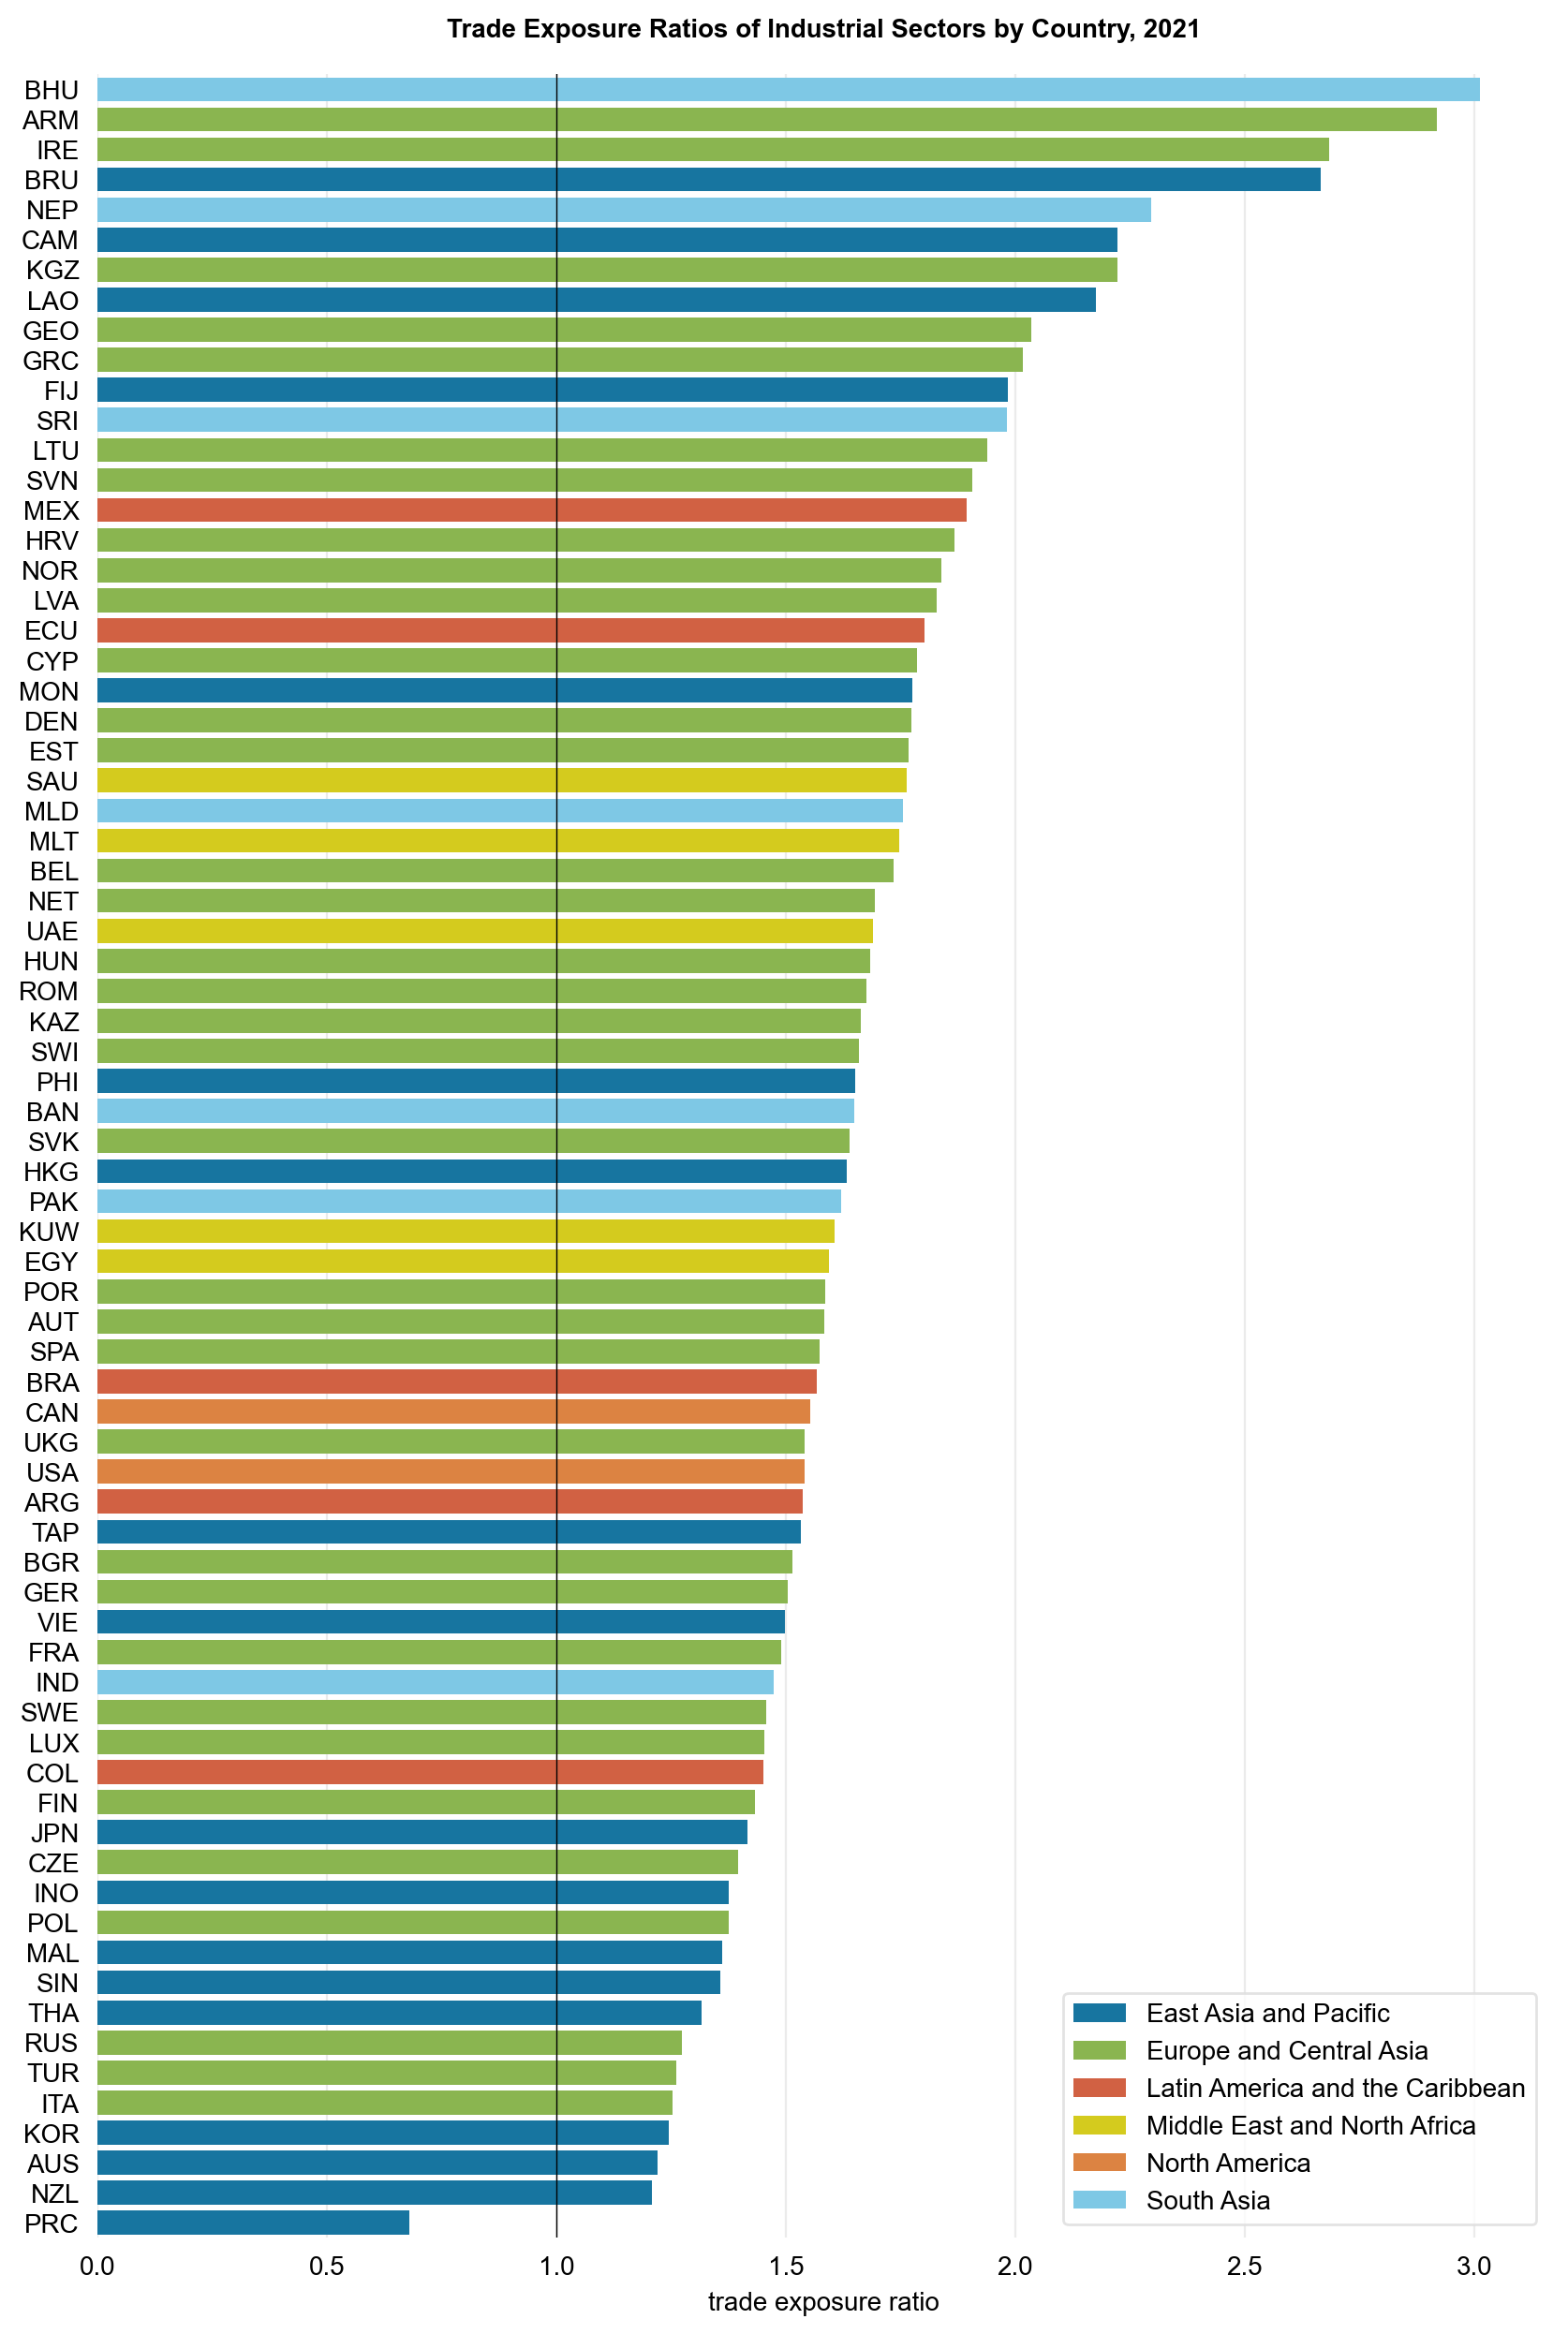

In [507]:
f, ax = plt.subplots(figsize=(10, 15), dpi=200)

regions_data = (
    pd.concat([te_2021[te_2021['region'] == region] for region in region_colors])
    .sort_values(by='te', ascending=False)
    )

sns.barplot(x=regions_data['te'],
            y=regions_data['country'],
            hue=regions_data['region'],
            palette=region_colors.values(), 
            hue_order=region_colors.keys(),
            dodge=False, 
            ax=ax, 
            errorbar=None, 
            zorder=2)

plt.axvline(x=1, color='black', linewidth=0.5)
plt.grid(axis='x', color='#EBEBEB') 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(left=False, bottom=False) 
plt.xlabel('trade exposure ratio', fontsize=10)
plt.ylabel('')
plt.title('Trade Exposure Ratios of Industrial Sectors by Country, 2021', y=1.01, fontsize=10, fontweight='bold')
legend = plt.legend(fontsize=10, loc='lower right')
legend.get_frame().set_edgecolor('#DDDDDD')
sns.despine(left=True, bottom=True)

#### C. EITE

GDR 2023 
- Chapter (Bo Meng): carbon leakage measurement
- Similar to COVID analysis 
- Emissions (aut) vs emissions (act)